In [5]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from imageio.v2 import imread

def readFlow(fn):
    """ Read .flo file in Middlebury format"""
    # Code adapted from:
    # http://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy

    # WARNING: this will work on little-endian architectures (eg Intel x86) only!
    # print 'fn = %s'%(fn)
    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            # print 'Reading %d x %d flo file\n' % (w, h)
            data = np.fromfile(f, np.float32, count=2 * int(w) * int(h))
            # Reshape testdata into 3D array (columns, rows, bands)
            # The reshape here is for visualization, the original code is (w,h,2)
            return np.resize(data, (int(h), int(w), 2))
def path_to_img_arr(path,to_crop = True):
  im = imread(path)
  h , w , _ = im.shape  
  new_h = h//64 *64
  new_w = w//64 * 64
  if to_crop:  
      im = im[(h-new_h)//2:(h+new_h)//2,(w-new_w)//2:(w+new_w)//2,:]
  return im

def warp(im, flow, alpha=1, interp=cv2.INTER_CUBIC):
    height, width, _ = flow.shape
    cart = np.dstack(np.meshgrid(np.arange(width), np.arange(height)))
    pixel_map = (cart + alpha * flow).astype(np.float32)
    warped = cv2.remap(
        im,
        pixel_map[:, :, 0],
        pixel_map[:, :, 1],
        interp)
    return warped

def warp2(curImg ,flow):
  h, w = flow.shape[:2]
  flow = -flow
  flow[:,:,0] += np.arange(w)
  flow[:,:,1] += np.arange(h)[:,np.newaxis]
  prevImg = cv2.remap(curImg, flow, None, cv2.INTER_LINEAR)
  return prevImg
def warp3(img,flo):
  batched_img = np.reshape(img, (1, *img.shape))
  torch_img = torch.from_numpy(batched_img)
  torch_img = torch.from_numpy(np.transpose(batched_img, (0, 3, 1, 2)))
  batched_flo = np.reshape(flo, (1, *flo.shape))
  torch_flo = torch.from_numpy(batched_flo)
  torch_flo = torch.from_numpy(np.transpose(batched_flo, (0, 3, 1, 2)))
  return warp_pwc(torch_img,torch_flo)

def warp_pwc(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow

    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow

    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = Variable(grid) + flo

    # scale grid to [-1,1]
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
    mask = nn.functional.grid_sample(mask, vgrid)

    mask[mask<0.999] = 0
    mask[mask>0] = 1

    return output*mask

def diff_show(path1 , path2):

    plt.figure(figsize=(5,5))
    image_ref = path_to_img_arr(path1)
    plt.imshow(image_ref)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(5,5))
    image_mod =path_to_img_arr(path2)
    plt.imshow(image_mod)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(image_mod, cv2.COLOR_BGR2GRAY) - cv2.cvtColor(image_ref, cv2.COLOR_BGR2GRAY))
    plt.axis('off')
    plt.show()

    plt.close()

In [6]:
sources = "../../sources/"
images = sources+"/images"
flow_res = sources+"/flows"
mod = images + "/demo_mod"
ref = images + "/demo_ref"
Xm1 = mod + "/openimage_0995.png"
Xo1 = ref + "/openimage_0995.png"
res_example = images + "/res_example"
flownet = flow_res + "/FlowNet2.flo"
spynet = flow_res + "/openimage_0995.flo"

In [7]:
#!python SpyNet/pred.py --model sintel-final --one $mod --two $ref --out $flow_res

In [8]:
!ls $flow_res

FlowNet2.flo  openimage_0922.flo  openimage_0995.flo


In [14]:
from PIL import Image


flow = flownet
is_resample2d = False 
flow_numpy = readFlow(flow)

Xm1_PIL = Image.open(Xm1).convert('RGB')
Xo1_PIL = Image.open(Xo1).convert('RGB')
if flow == flownet:
    Xm1_PIL = Xm1_PIL.resize([384,384])
    Xo1_PIL = Xo1_PIL.resize([384,384])
Xm1_numpy = np.array(Xm1_PIL)


/tmp/ipykernel_2949/268263338.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = np.fromfile(f, np.float32, count=2 * int(w) * int(h))
/tmp/ipykernel_2949/268263338.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.resize(data, (int(h), int(w), 2))


In [15]:
#use resample2d FlowNet2.0
import torch
from FlowNet2.resample2d_package.resample2d import Resample2d
from torchvision.transforms.functional import pil_to_tensor

resample = Resample2d()
def toTensor(x_numpy,type =torch.float):
    res = torch.tensor(x_numpy,dtype = type)
    return res.permute(2,0,1).unsqueeze(0).cuda()

Xm1_torch = pil_to_tensor(Xm1_PIL).cuda().to(torch.float)
Xo1_torch = pil_to_tensor(Xo1_PIL).cuda().to(torch.float)
flow_torch = toTensor(flow_numpy).contiguous()


In [18]:
xpair= [Xm1_torch,Xo1_torch]
xpair.shape

AttributeError: 'list' object has no attribute 'shape'

In [47]:
flow_torch

tensor([[[[-0.0171, -0.0198, -0.0107,  ..., -0.0047,  0.0170,  0.0585],
          [-0.0203, -0.0325, -0.0277,  ..., -0.0172,  0.0079,  0.0521],
          [-0.0210, -0.0428, -0.0430,  ..., -0.0232,  0.0013,  0.0434],
          ...,
          [ 0.0601,  0.0534,  0.0547,  ...,  0.0115,  0.0403,  0.0114],
          [ 0.0409,  0.0398,  0.0555,  ..., -0.0115,  0.0261, -0.0110],
          [ 0.0034,  0.0190,  0.0583,  ...,  0.0072,  0.0509,  0.0043]],

         [[ 0.0422,  0.0302,  0.0201,  ...,  0.0097, -0.0048, -0.0114],
          [ 0.0417,  0.0286,  0.0167,  ..., -0.0197, -0.0434, -0.0460],
          [ 0.0484,  0.0352,  0.0224,  ..., -0.0479, -0.0698, -0.0805],
          ...,
          [ 0.1148,  0.1037,  0.0864,  ..., -0.0116,  0.0297,  0.0541],
          [ 0.1078,  0.1027,  0.0925,  ..., -0.0061,  0.0351,  0.0687],
          [ 0.1175,  0.1171,  0.1231,  ...,  0.0094,  0.0426,  0.0849]]]],
       device='cuda:0')

In [25]:
warp2_kit = (Xm1_numpy , flow_numpy ,warp2)
resample2d_kit = (Xm1_torch , flow_torch*1e-4 , resample) 

In [42]:
def warping(kit):
    im , flow ,warp = kit
    return warp(im,flow)

im_a = warping(resample2d_kit)
im_b = warping(warp2_kit)
im_b =torch.tensor(im_b).permute(2,0,1).unsqueeze(0).cuda()
im_a = im_a.squeeze(0)

new resample
before forward  
 output = torch.Size([1, 3, 417, 430]) 
after forward 
 output = torch.Size([1, 3, 417, 430])


In [45]:
im = im_a
im

tensor([[[ 50.0000,  46.0000,  50.0000,  ..., 249.0000, 255.0000, 219.0000],
         [ 57.0000,  51.0000,  56.0000,  ..., 254.0000, 255.0000, 242.9999],
         [ 52.0000,  49.0000,  58.0000,  ..., 251.0000, 249.0000, 253.9999],
         ...,
         [198.0000, 202.0000, 205.0000,  ...,  42.0000,  35.0000,  35.0000],
         [198.0000, 200.0000, 199.0000,  ...,  49.0000,  38.0000,  36.0000],
         [198.0000, 197.0000, 197.0000,  ...,  38.0000,  39.0000,  42.0000]],

        [[ 33.0000,  32.0000,  37.0000,  ..., 251.0000, 255.0000, 211.0000],
         [ 40.0000,  37.0000,  43.0000,  ..., 255.0000, 255.0000, 234.9999],
         [ 35.0000,  35.0000,  45.0000,  ..., 255.0000, 250.0000, 247.9999],
         ...,
         [ 81.0000,  85.0000,  86.9999,  ...,  29.0000,  22.0000,  22.0000],
         [ 81.0000,  83.0000,  81.0000,  ...,  36.0000,  25.0000,  23.0000],
         [ 81.0000,  78.0000,  78.0000,  ...,  25.0000,  26.0000,  29.0000]],

        [[ 25.0000,  23.0000,  29.0000,  ...

torch.float64


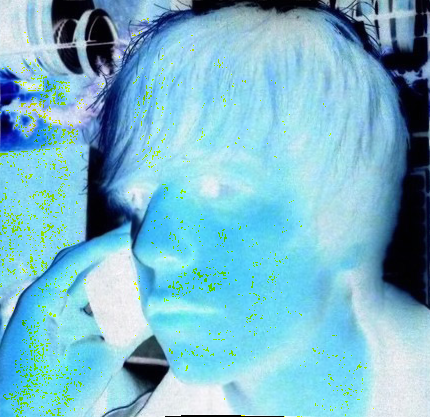

In [40]:
from torchvision.transforms import ToPILImage
print(im.dtype)
makePIL =ToPILImage()
im = im.squeeze()
makePIL(im)

In [ ]:

im = im.squeeze()
im = im.to(torch.float)
print(im)
im_anew = im 
im = im_b
im = im.squeeze()
im = im.to(torch.float)


In [ ]:


print(im.shape)


In [ ]:
rgb_mean = inputs.contiguous().view(inputs.size()[:2]+(-1,)).mean(dim=-1).view(inputs.size()[:2] + (1,1,1,))
x = (inputs - rgb_mean) / 255

In [ ]:


Xm1_torch = pil_to_tensor(Xm1_PIL)
Xm1_torch.shape